Dependencies

In [1]:
import cv2
import numpy as np
from typing import Tuple, Optional
import matplotlib.pyplot as plt
import inspect
from pathlib import Path
from typing import Union, List

Contrast Stretching

In [2]:
def contrast_stretch(img_rgb):
        img_float = img_rgb.astype(np.float32)
        min_val = float(np.min(img_float))
        max_val = float(np.max(img_float))
        if max_val <= min_val + 1e-6:
            return img_rgb.copy()
        stretched = (img_float - min_val) / (max_val - min_val) * 255.0
        return np.clip(stretched, 0, 255).astype(np.uint8)

Noise Filtering

In [3]:
def denoise(img_rgb, h=2.5, hColor=5, templateWindowSize=7, searchWindowSize=21, **kwargs):
        # Ensure valid odd window sizes as required by OpenCV
        templateWindowSize = int(templateWindowSize)
        searchWindowSize = int(searchWindowSize)
        if templateWindowSize % 2 == 0:
            templateWindowSize += 1
        if searchWindowSize % 2 == 0:
            searchWindowSize += 1

        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        filtered_bgr = cv2.fastNlMeansDenoisingColored(
            img_bgr, None,
            h=float(h),
            hColor=float(hColor),
            templateWindowSize=templateWindowSize,
            searchWindowSize=searchWindowSize
        )
        return cv2.cvtColor(filtered_bgr, cv2.COLOR_BGR2RGB)

Gamma Correction

In [4]:
def gamma_correction(img_rgb, gamma=3.2):
        normalized = img_rgb.astype(np.float32) / 255.0
        corrected = np.power(normalized, 1.0 / float(gamma))
        return np.clip(corrected * 255.0, 0, 255).astype(np.uint8)

White Balancing (Gray World assumption)

In [5]:
def white_balance(img_rgb):
        result = img_rgb.astype(np.float32)
        avg = np.mean(result, axis=(0, 1))  # RGB means
        avg_gray = float(np.mean(avg))
        # avoid division by zero
        scale = np.where(avg <= 1e-6, 1.0, avg_gray / avg)
        result *= scale
        return np.clip(result, 0, 255).astype(np.uint8)

Contrast Limited Adaptive Histogram Equalization (Contrast Enhance + Tone correction)

In [6]:
def clahe_yuv_and_tone_correction_lab(
    img_rgb, 
    clipLimit1=1.0, tileGridSize1=(2, 2), 
    clipLimit2=0.1, tileGridSize2=(1, 1),
    shadow_strength=0.3, highlight_strength=0.3
):
    """
    Tone mapping & contrast enhancement using double CLAHE + shadow/highlight correction.
    
    shadow_strength: 0.0 - 1.0, amount to lift shadows
    highlight_strength: 0.0 - 1.0, amount to recover highlights
    """
    
    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    
    # ---------- Step 1: CLAHE on YUV luminance ----------
    yuv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV)
    clahe_yuv = cv2.createCLAHE(clipLimit=clipLimit1, tileGridSize=tileGridSize1)
    yuv[:, :, 0] = clahe_yuv.apply(yuv[:, :, 0])
    enhanced_bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    
    # ---------- Step 2: CLAHE on LAB lightness ----------
    lab = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe_lab = cv2.createCLAHE(clipLimit=clipLimit2, tileGridSize=tileGridSize2)
    cl = clahe_lab.apply(l)
    lab_clahe = cv2.merge((cl, a, b))
    img_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    
    # ---------- Step 3: Shadow & Highlight Correction ----------
    # Work in LAB again for tone mapping
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    L = L.astype(np.float32) / 255.0  # normalize [0,1]

    # Shadows: lift darks using a gamma-like adjustment
    shadow_mask = (L < 0.5)
    L[shadow_mask] = L[shadow_mask] + shadow_strength * (0.5 - L[shadow_mask])

    # Highlights: compress brights
    highlight_mask = (L > 0.5)
    L[highlight_mask] = L[highlight_mask] - highlight_strength * (L[highlight_mask] - 0.5)

    # Re-normalize back to 8-bit
    L = np.clip(L * 255, 0, 255).astype(np.uint8)
    lab_corrected = cv2.merge((L, A, B))
    final_bgr = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)

    # Convert back to RGB
    return cv2.cvtColor(final_bgr, cv2.COLOR_BGR2RGB)


Saturation Enhancement (Adaptive + Fixed)

In [7]:
def saturation_enhance(img_rgb, max_boost=1.6, min_boost=1.1, fixedEnhance=1.36):
        hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)
        normalized_s = s.astype(np.float32) / 255.0
        adaptive_scale = float(max_boost) - (float(max_boost) - float(min_boost)) * normalized_s
        s_enhanced = np.clip(s.astype(np.float32) * adaptive_scale * fixedEnhance, 0, 255).astype(np.uint8)
        enhanced_hsv = cv2.merge([h, s_enhanced, v])
        return cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2RGB)


Gaussian Smoothening

In [8]:
def gaussian_smooth(img_rgb, ksize=3, sigma=1.2):
        k = int(ksize)
        if k % 2 == 0:
            k += 1
        return cv2.GaussianBlur(img_rgb, (k, k), float(sigma))

Median Smoothening

In [9]:
def median_blur_image(image, ksize=3):
    if ksize % 2 == 0:
        ksize += 1
    return cv2.medianBlur(image, ksize)

Image Sharpening (Unsharp Masking)

In [10]:
def unsharp_mask(img_rgb, amount=2.0, radius=1.5):
        img_f = img_rgb.astype(np.float32)
        blurred = cv2.GaussianBlur(img_f, (0, 0), float(radius))
        sharpened = np.clip(img_f + float(amount) * (img_f - blurred), 0, 255)
        return sharpened.astype(np.uint8)

Image Sharpening (Filter 2D)

In [11]:
def sharpen_subtle(image, strength=0.002):
    # Sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]], dtype=np.float32) * strength
    kernel[1, 1] += 1  # Add identity to preserve original features

    # Apply sharpening filter
    sharpened = cv2.filter2D(image, -1, kernel)

    # Clip and return
    return np.clip(sharpened, 0, 255).astype(np.uint8)


Implemention Wizard

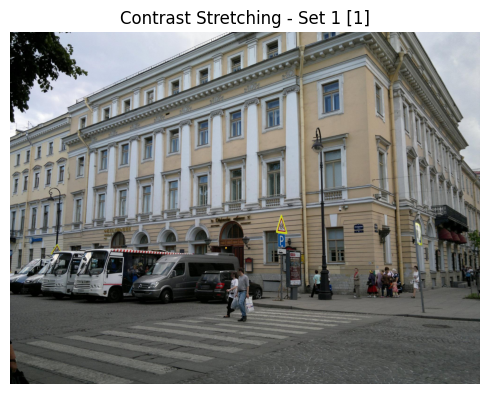

Please enter 'c' to Continue or 's' to Skip.
Continuing with Contrast Stretching, only one result available.


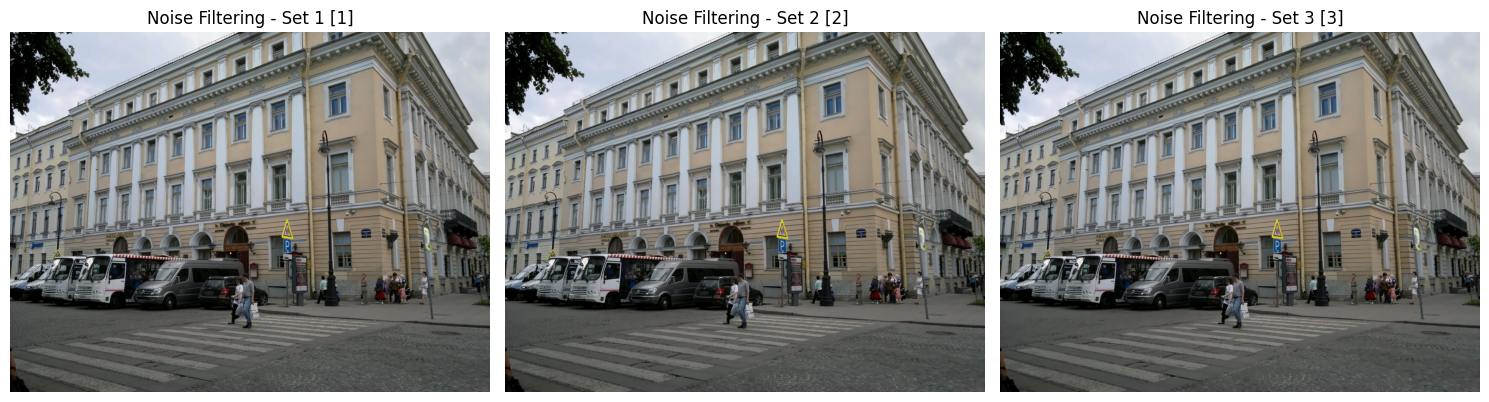

Continuing with Noise Filtering, option 2


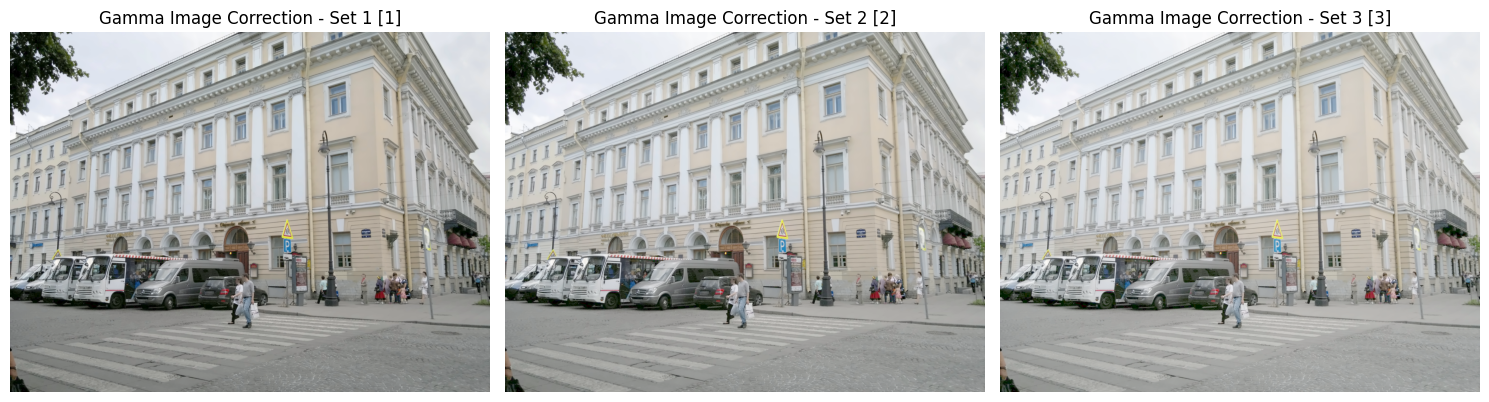

Continuing with Gamma Image Correction, option 1


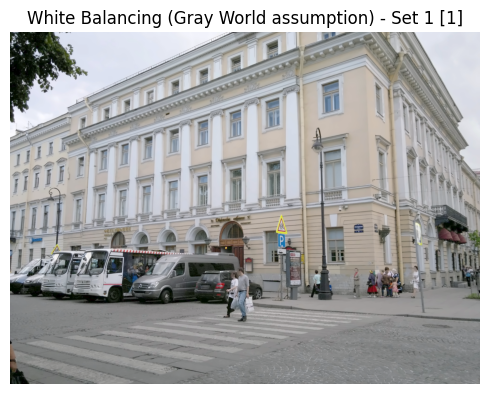

Skipping stage: White Balancing (Gray World assumption)


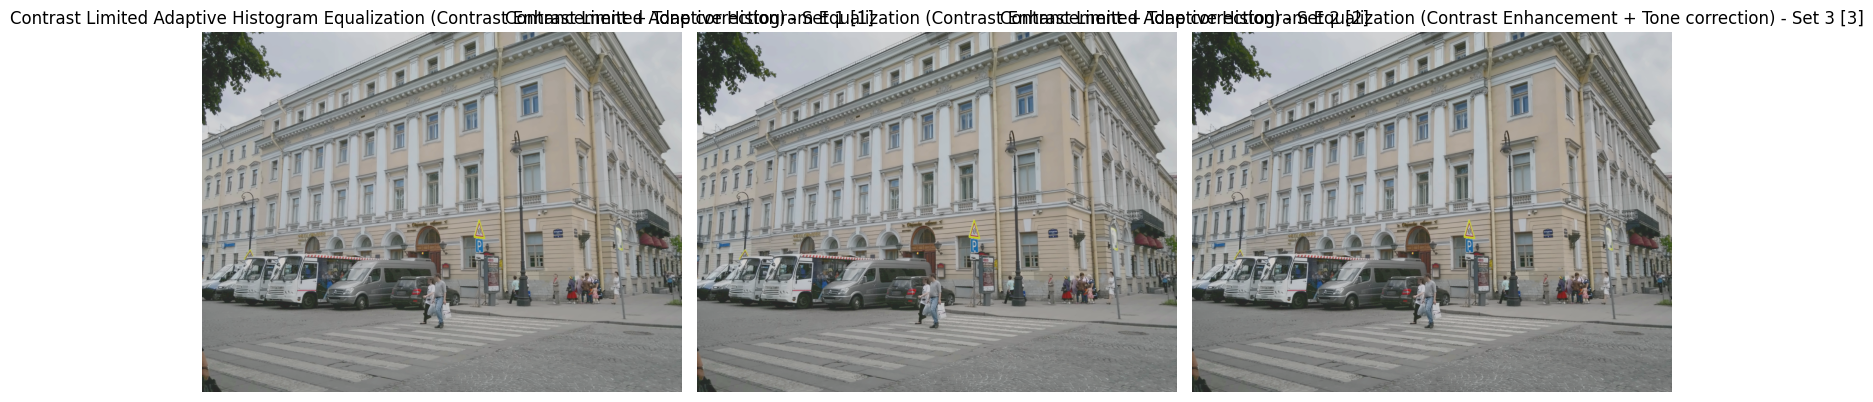

Continuing with Contrast Limited Adaptive Histogram Equalization (Contrast Enhancement + Tone correction), option 2


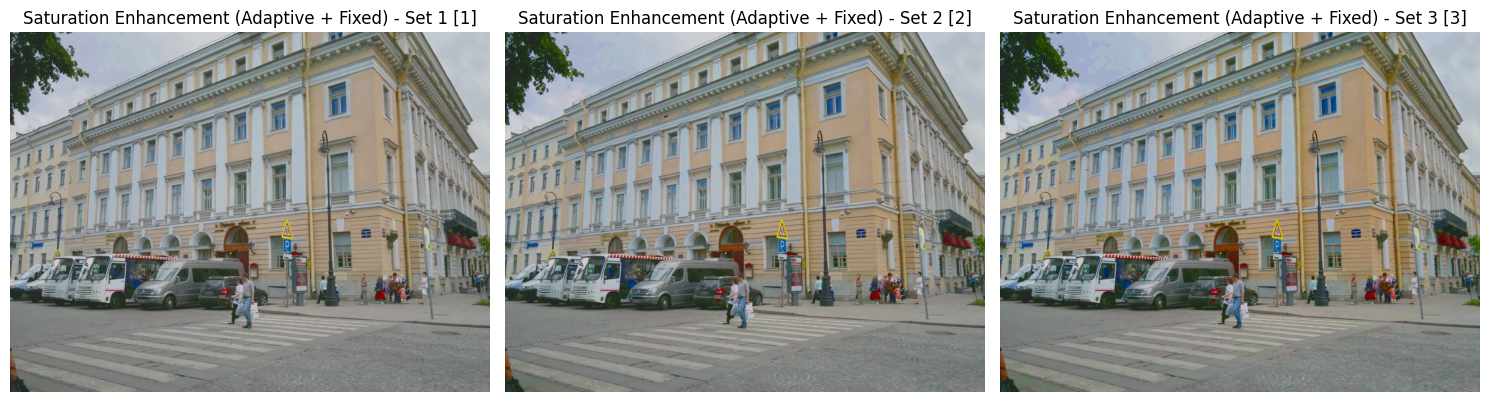

Continuing with Saturation Enhancement (Adaptive + Fixed), option 2


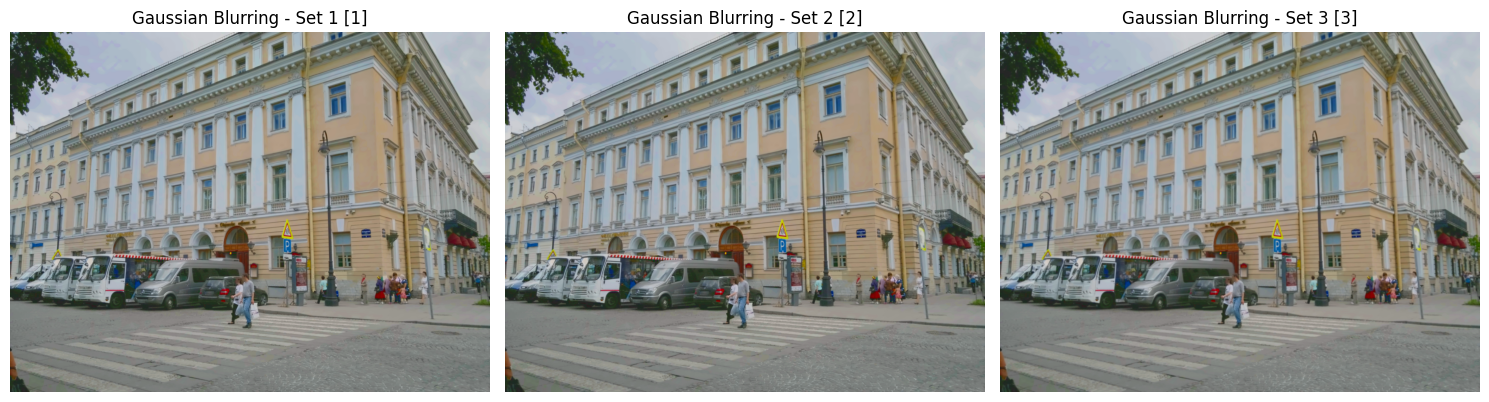

Skipping stage: Gaussian Blurring


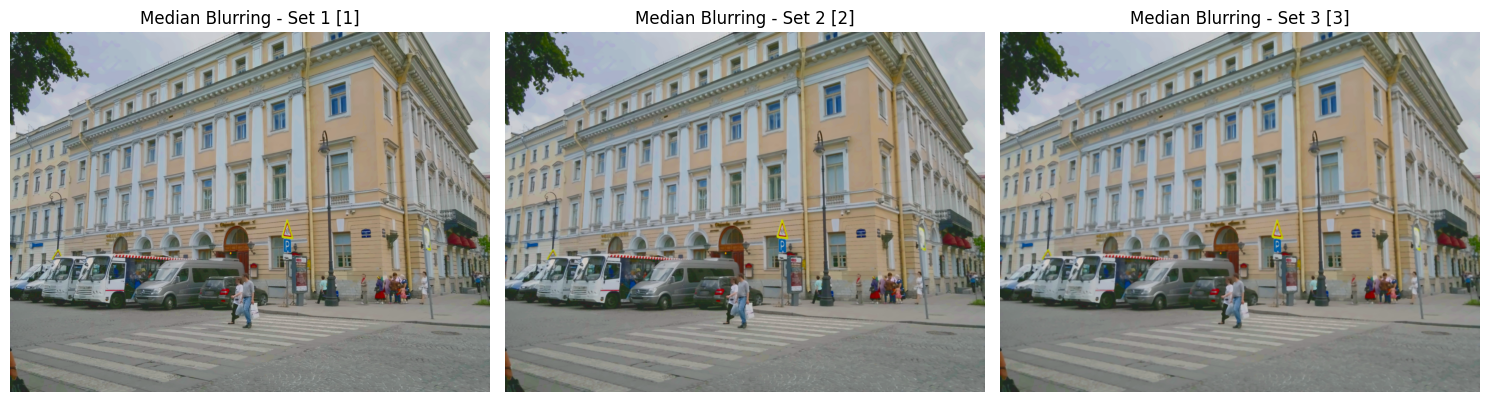

Skipping stage: Median Blurring


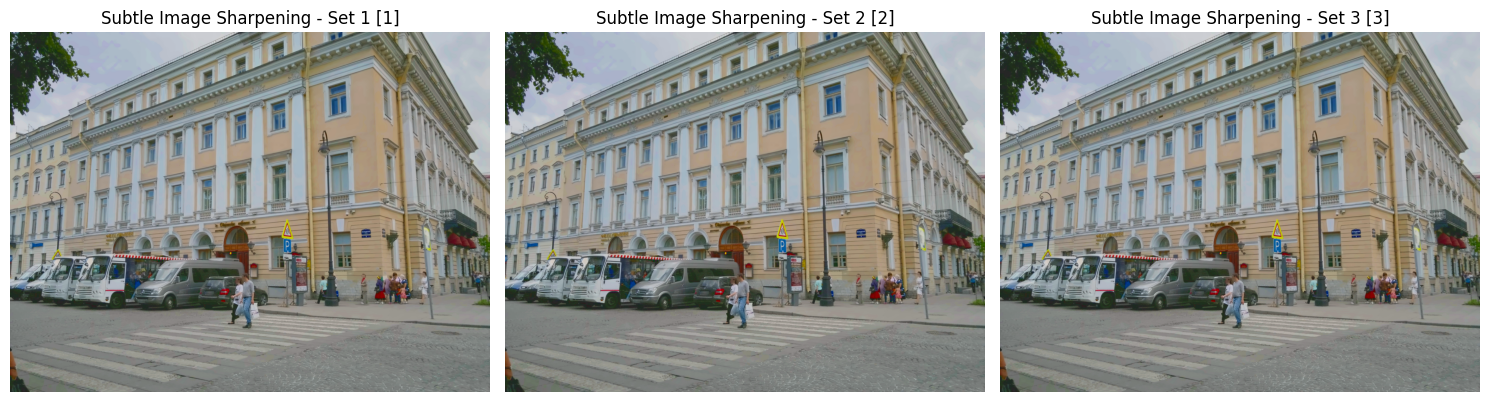

In [ ]:
def show_images(images, titles):
    """Display images side by side without asking to choose."""
    if not images:
        raise ValueError("No images to show for this stage.")
    num = len(images)
    plt.figure(figsize=(5*num, 5))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, num, i)
        plt.imshow(img)  # RGB images shown directly
        plt.title(f"{title} [{i}]")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_comparison(original_image, final_image):
    """Display side-by-side comparison of original and final images."""
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Input Image")
    plt.axis("off")
    
    # Final enhanced image
    plt.subplot(1, 2, 2)
    plt.imshow(final_image)
    plt.title("Final Enhanced Output")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    print("Side-by-side comparison displayed above.")

def ask_continue_or_skip():
    """Ask whether to continue with a stage or skip it."""
    while True:
        resp = input("Pass this stage's result to next stage or skip this stage? [c=Continue/s=Skip]: ").strip().lower()
        if resp in ("c", "continue"):
            return "continue"
        if resp in ("s", "skip"):
            return "skip"
        print("Please enter 'c' to Continue or 's' to Skip.")

def ask_selection(num_options):
    """Ask user to select one of the given options."""
    while True:
        try:
            choice = int(input(f"Select one option [1-{num_options}]: ").strip())
            if 1 <= choice <= num_options:
                return choice
            print(f"Please enter a number between 1 and {num_options}.")
        except Exception:
            print("Invalid input. Please enter an integer.")

def process_stage(image, stage_name, function, param_sets):
    # Ensure at least one parameter set
    if not param_sets:
        param_sets = [{}]

    results = []
    for params in param_sets:
        # Filter params to only those accepted by the function
        sig = inspect.signature(function)
        accepted = {name for name, p in sig.parameters.items() if p.kind in (p.POSITIONAL_OR_KEYWORD, p.KEYWORD_ONLY)}
        filtered = {k: v for k, v in params.items() if k in accepted}
        results.append(function(image, **filtered))

    titles = [f"{stage_name} - Set {i+1}" for i in range(len(results))]
    show_images(results, titles)

    # Ask whether to skip or continue
    decision = ask_continue_or_skip()
    if decision == "skip":
        print(f"Skipping stage: {stage_name}")
        return image

    # If only one result, no need to ask for selection
    if len(results) == 1:
        print(f"Continuing with {stage_name}, only one result available.")
        return results[0]
    else:
        choice = ask_selection(len(results))
        print(f"Continuing with {stage_name}, option {choice}")
        return results[choice - 1]

# Example integration (pipeline definition remains the same as you provided)
pipeline_stages = [
    {
        "name": "Contrast Stretching",
        "function": contrast_stretch,
        "params": []
    },
    {
        "name": "Noise Filtering",
        "function": denoise,
        "params": [
            {"h": 1.5, "hColor": 3},
            {"h": 2.5, "hColor": 5},
            {"h": 3.5, "hColor": 7}
        ]
    },
    {
        "name": "Gamma Image Correction",
        "function": gamma_correction,
        "params": [
            {"gamma": 1.8},
            {"gamma": 2.2},
            {"gamma": 2.6}
        ]
    },
    {
        "name": "White Balancing (Gray World assumption)",
        "function": white_balance,
        "params": []  # only one option
    },
    {
        "name": "Contrast Limited Adaptive Histogram Equalization (Contrast Enhancement + Tone correction)",
        "function": clahe_yuv_and_tone_correction_lab,
        "params": [
            {"clipLimit1": 0.8, "tileGridSize1": (2, 2), "clipLimit2": 0.08, "tileGridSize2": (1, 1)},
            {"clipLimit1": 1.0, "tileGridSize1": (2, 2), "clipLimit2": 0.1, "tileGridSize2": (1, 1)},
            {"clipLimit1": 1.2, "tileGridSize1": (2, 2), "clipLimit2": 0.12, "tileGridSize2": (1, 1)}
        ]
    },
    {
        "name": "Saturation Enhancement (Adaptive + Fixed)",
        "function": saturation_enhance,
        "params": [
            {"max_boost": 1.4, "min_boost": 1.05, "fixedEnhance": 1.25},
            {"max_boost": 1.6, "min_boost": 1.1, "fixedEnhance": 1.36},
            {"max_boost": 1.8, "min_boost": 1.15, "fixedEnhance": 1.5}
        ]
    },
    {
        "name": "Gaussian Blurring",
        "function": gaussian_smooth,
        "params": [
            {"ksize": 3, "sigma": 1.0},
            {"ksize": 3, "sigma": 1.2},
            {"ksize": 5, "sigma": 1.4}
        ]
    },
    {
        "name": "Median Blurring",
        "function": median_blur_image,
        "params": [
             {"ksize": 3},
             {"ksize": 5},
             {"ksize": 7}
        ]
    },
    {
        "name": "Subtle Image Sharpening",
        "function": sharpen_subtle,
        "params": [
            {"strength": 0.001},
            {"strength": 0.002},
            {"strength": 0.003}
        ]
    },
    {
        "name": "Strong Image Sharpening",
        "function": unsharp_mask,
        "params": [
            {"amount": 1.5, "radius": 1.0},
            {"amount": 2.0, "radius": 1.5},
            {"amount": 2.5, "radius": 2.0}
        ]
    }
]

##Beginning of Wizard implementation##
image_path = "C:/Users/gaura/Current_Code_Files/Internship_Project/Backup_Folder/BatchedDataset/Batch1/Exterior_Dataset/0BYZodoqfSIog8Wq_86Pcw.jpg"
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Could not read image: {image_path}")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
# Store the original image for comparison
original_image = img.copy()
    
for stage in pipeline_stages:
    img = process_stage(img, stage["name"], stage["function"], stage["params"])
    
# Save the final output
cv2.imwrite("final_output.jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Save in BGR
print("Pipeline completed. Saved as final_output.jpg")
    
# Show side-by-side comparison
print("\n" + "="*50)
print("SIDE-BY-SIDE COMPARISON")
print("="*50)
show_comparison(original_image, img)